<a href="https://colab.research.google.com/github/Dipak22/DeepLearning/blob/master/tabular_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1

In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
creds = '{"username":"dasd23","key":"5e8d607b5294b8bf0015544cf3d6d304"}'

In [4]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [6]:
Path.BASE_PATH = path

In [8]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 48.4M/48.4M [00:00<00:00, 86.2MB/s]


(#7) [Path('Valid.csv'),Path('TrainAndValid.csv'),Path('Machine_Appendix.csv'),Path('ValidSolution.csv'),Path('Test.csv'),Path('median_benchmark.csv'),Path('random_forest_benchmark_test.csv')]

In [12]:
cd /root/.fastai/archive/bluebook-for-bulldozers

[Errno 2] No such file or directory: '/root/.fastai/archive/bluebook-for-bulldozers'
/content


In [13]:
!kaggle competitions download -c bluebook-for-bulldozers

 95% 46.0M/48.4M [00:02<00:00, 23.8MB/s]
100% 48.4M/48.4M [00:03<00:00, 16.7MB/s]


In [19]:
path = Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [20]:
shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

In [9]:
path.ls()

(#15) [Path('Valid.csv'),Path('TrainAndValid.zip'),Path('TrainAndValid.csv'),Path('Machine_Appendix.csv'),Path('Train.zip'),Path('TrainAndValid.7z'),Path('Data Dictionary.xlsx'),Path('ValidSolution.csv'),Path('Valid.7z'),Path('Test.csv'),Path('median_benchmark.csv'),Path('Train.7z'),Path('Valid.zip'),Path('bluebook-for-bulldozers.zip'),Path('random_forest_benchmark_test.csv')]

In [10]:
df = pd.read_csv(path/'TrainAndValid.csv',low_memory = False)

In [11]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [12]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [13]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [14]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

,ProductSize
0,NaN
1,Medium
2,NaN
3,Small
4,NaN
...,...
412693,Mini
412694,Mini
412695,Mini
412696,Mini


In [15]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [16]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,11.097410,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,10.950807,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,9.210340,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,10.558414,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,9.305651,1057373,17311,...,NaN,NaN,NaN,NaN


In [17]:
df = add_datepart(df,'saledate')

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [18]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [19]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [20]:
procs = [Categorify, FillMissing]

In [21]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [22]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [23]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [24]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [45]:
to.classes['ProductSize']

['#na#', 'Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

In [46]:
save_pickle(path/'to.pkl',to)

In [50]:
to = load_pickle(path/'to.pkl')

In [25]:
to.items.head(5)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1
3,1139251,10.558414,1026470,332,...,1,1.305763e+09,1,1
4,1139253,9.305651,1057373,17311,...,1,1.248307e+09,1,1


In [26]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [28]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

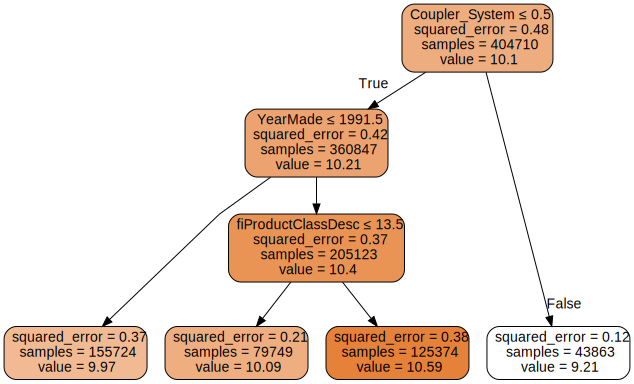

In [54]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


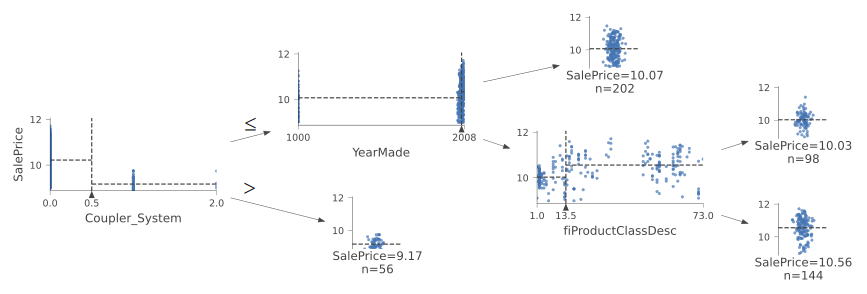

In [55]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [29]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [30]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

NameError: name 'samp_idx' is not defined

In [58]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [32]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [60]:
m_rmse(m, xs, y)

0.0

In [61]:
m_rmse(m, valid_xs, valid_y)

0.332239

In [62]:
m.get_n_leaves(), len(xs)

(324338, 404710)

In [33]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.243049, 0.309348)

In [34]:
m.get_n_leaves()

12432

In [35]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [36]:
m = rf(xs, y);

In [37]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171391, 0.232622)

In [38]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [39]:
preds.shape

(40, 7988)

In [40]:
preds_std = preds.std(0)

In [41]:
preds_std[:5]

array([0.26290773, 0.12360072, 0.12031834, 0.25601166, 0.13338294])

In [42]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [43]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.171131
30,Coupler_System,0.110086
6,ProductSize,0.096267
7,fiProductClassDesc,0.084785
54,ModelID,0.057599
65,saleElapsed,0.051302
3,fiSecondaryDesc,0.048770
32,Hydraulics_Flow,0.048373
31,Grouser_Tracks,0.042956
12,Enclosure,0.041949


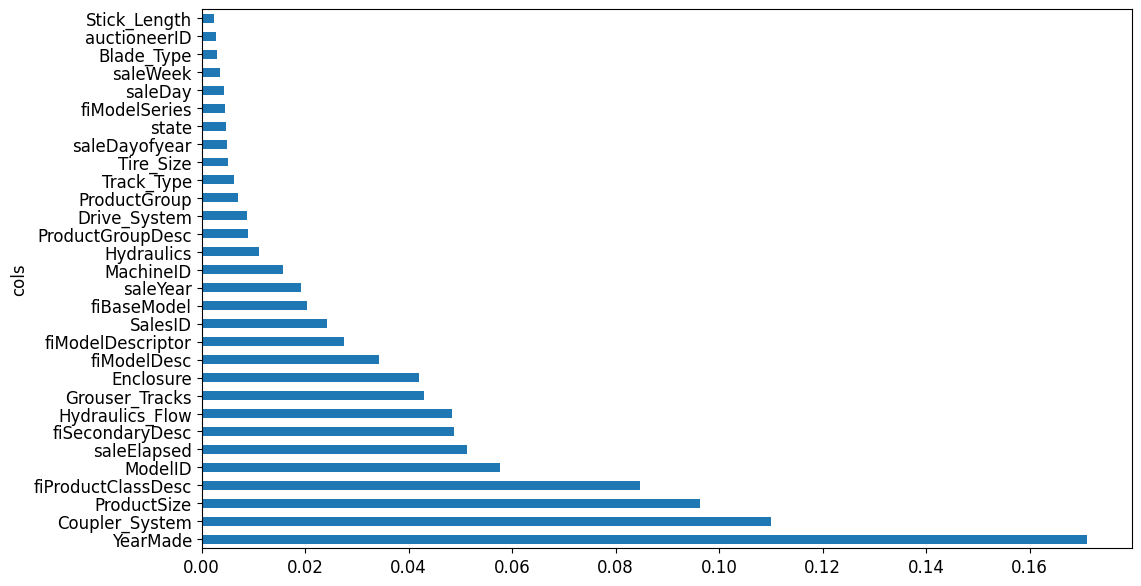

In [44]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [45]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [46]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [47]:
m = rf(xs_imp, y)

In [48]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181882, 0.231275)

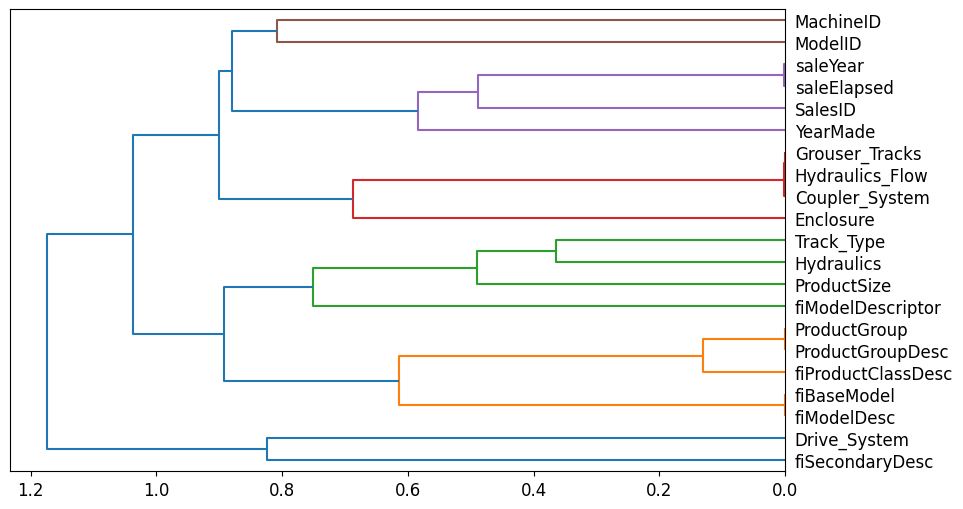

In [49]:
#Removing redundant columns
cluster_columns(xs_imp)

In [50]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [51]:
get_oob(xs_imp)

0.875251493545431

In [52]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8745921972533767,
 'saleElapsed': 0.8705193144524301,
 'ProductGroupDesc': 0.8752227122398043,
 'ProductGroup': 0.8760680002572944,
 'fiModelDesc': 0.8743103210838425,
 'fiBaseModel': 0.8750969233864647,
 'Hydraulics_Flow': 0.8756716972000468,
 'Grouser_Tracks': 0.8764817119071073,
 'Coupler_System': 0.8762944845100381}

In [53]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8722748760821868

In [54]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [55]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [56]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [57]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183773, 0.232628)

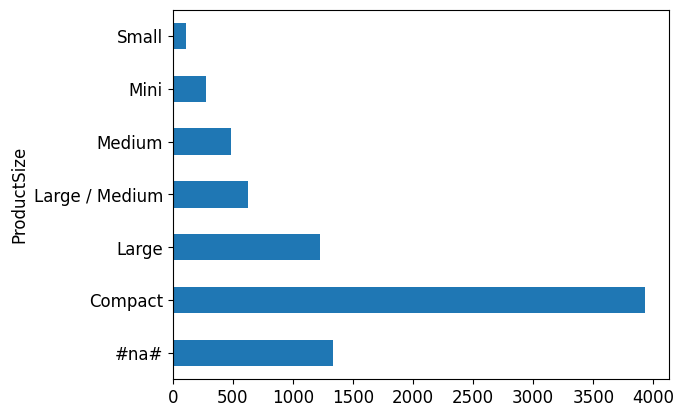

In [58]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

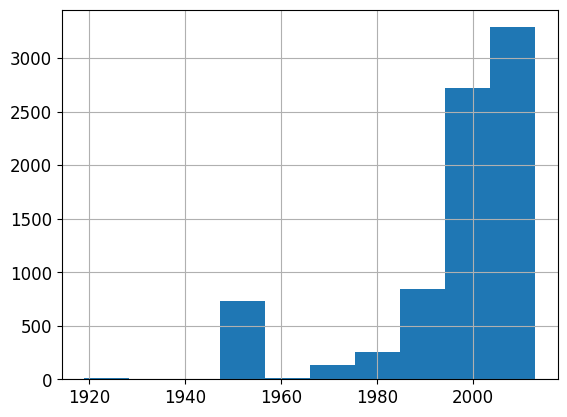

In [59]:
ax = valid_xs_final['YearMade'].hist()

In [60]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [61]:
row = valid_xs_final.iloc[:5]

In [62]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [63]:
prediction[0], bias[0], contributions[0].sum()

(array([10.05456889]), 10.104259437935829, -0.04969054403651507)

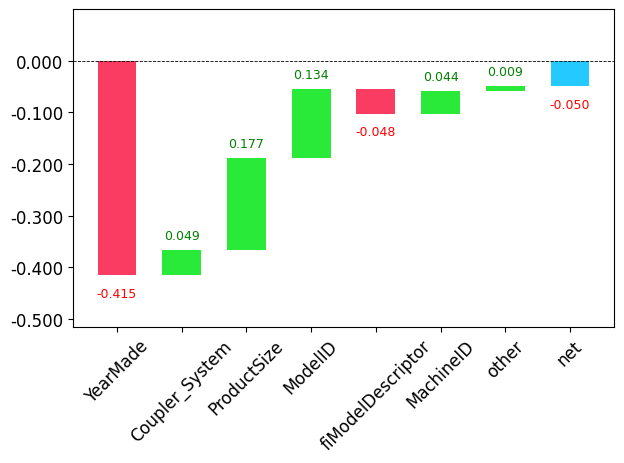

In [64]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
          rotation_value=45,formatting='{:,.3f}');

In [66]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [68]:
df_nn_final = df_nn[list(xs_final.columns) + [dep_var]]

In [69]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [70]:
df_nn_final[cat_nn].nunique()

,0
YearMade,73
Coupler_System,2
ProductSize,6
fiProductClassDesc,74
ModelID,5281
fiSecondaryDesc,177
Hydraulics_Flow,3
Enclosure,6
fiModelDesc,5059
fiModelDescriptor,140


In [72]:
cat_nn.remove('fiModelDescriptor')

In [74]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [75]:
dls = to_nn.dataloaders(1024)

In [76]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

In [77]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0002290867705596611)

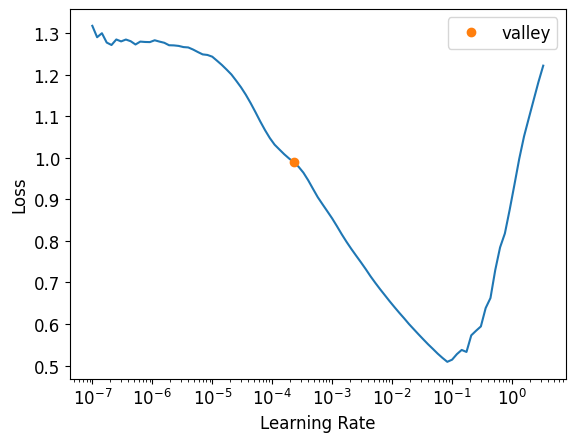

In [78]:
learn.lr_find()

In [79]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.062887,0.121867,00:36
1,0.051521,0.062778,00:33
2,0.045561,0.057146,00:32
3,0.041985,0.055321,00:33
4,0.039681,0.053153,00:33


In [80]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.230549